In [19]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import *
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import datetime
from keras.utils import plot_model
from tensorflow.keras.applications import MobileNetV2  # Import MobileNetV2
from tensorflow.keras.utils import image_dataset_from_directory

In [20]:
models_path = "./models/"

training_path = "C:/Users/AADIL/OneDrive/Documents/WasteImagesDataset/TRAIN"
test_path = "C:/Users/AADIL/OneDrive/Documents/WasteImagesDataset/TEST"
validation_path = "C:/Users/AADIL/OneDrive/Documents/WasteImagesDataset/VAL"

IMAGE_WIDTH = 192
IMAGE_HEIGHT = 192
BATCH_SIZE = 32
NUM_CLASSES = 4
RANDOM_SEED = 42

In [21]:
train_dataset = image_dataset_from_directory(
    training_path,
    label_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

validation_dataset = image_dataset_from_directory(
    validation_path,
    label_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

test_dataset = image_dataset_from_directory(
    test_path,
    label_mode='categorical',
    shuffle=False,
    seed=RANDOM_SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 2797 files belonging to 4 classes.
Found 755 files belonging to 4 classes.
Found 724 files belonging to 4 classes.


In [22]:
def plot_accuracy_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  best_loss_epoch = np.argmin(val_loss)
  best_loss = np.min(val_loss)
  best_acc = val_acc[best_loss_epoch]

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'bo', label='Validation loss')
  plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
  print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")

def eval (model):
  y_score = model.predict(test_dataset)
  test_loss, test_acc = model.evaluate(test_dataset)
  print(f"Test accuracy: {test_acc:.3f}, test loss: {test_loss:.3f}")
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
  print("Classification report: ")
  print(type(y_true))
  print(type(y_pred))
  print(y_pred.argmax(axis=1))
  print(metrics.classification_report(y_true.numpy().argmax(axis=1),y_pred.argmax(axis=1),digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true.numpy().argmax(axis=1), y_pred.argmax(axis=1))
     

In [23]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
  layers.Rescaling(1./255)
])

# Load MobileNetV2 without the top classification layer
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)
)

# Freeze the base model layers
base_model.trainable = False

# Create the new model on top
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

model_name = "MobileNetV2_TransferLearning"
model_path = os.path.join(models_path, model_name)
img_path = os.path.join(model_path, 'MobileNetV2_TransferLearning.png')
plot_model(model, show_shapes=True, to_file=img_path, dpi=64)

9406464/9406464 [==============================] - 2s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 mobilenetv2_1.00_192 (Func  (None, 6, 6, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_5 (Dense)             (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                              

In [24]:
def compile_and_fit(model, model_name, model_path, learning_rate=0.0001, optimizer='adam', train_dataset=train_dataset):

  save_path = os.path.join(model_path, model_name + '.h5')

  if learning_rate is not None:
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

  callbacks_list = [
    keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=1e-3,
      patience=5,),

    keras.callbacks.ModelCheckpoint(
      filepath = save_path,
      monitor="val_loss",
      verbose=1,
      save_best_only=True)]

  history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=callbacks_list)
  plot_accuracy_loss(history)

Epoch 1/30
88/88 [==============================] - ETA: 0s - loss: 1.0547 - accuracy: 0.5513
Epoch 1: val_loss improved from inf to 1.19059, saving model to ./models/MobileNetV2_TransferLearning\MobileNetV2_TransferLearning.h5
88/88 [==============================] - 119s 1s/step - loss: 1.0547 - accuracy: 0.5513 - val_loss: 1.1906 - val_accuracy: 0.4967
Epoch 2/30
88/88 [==============================] - ETA: 0s - loss: 0.8625 - accuracy: 0.6410
Epoch 2: val_loss improved from 1.19059 to 1.08290, saving model to ./models/MobileNetV2_TransferLearning\MobileNetV2_TransferLearning.h5
88/88 [==============================] - 113s 1s/step - loss: 0.8625 - accuracy: 0.6410 - val_loss: 1.0829 - val_accuracy: 0.5391
Epoch 3/30
88/88 [==============================] - ETA: 0s - loss: 0.7863 - accuracy: 0.6854
Epoch 3: val_loss improved from 1.08290 to 1.02629, saving model to ./models/MobileNetV2_TransferLearning\MobileNetV2_TransferLearning.h5
88/88 [==============================] - 105s 1s

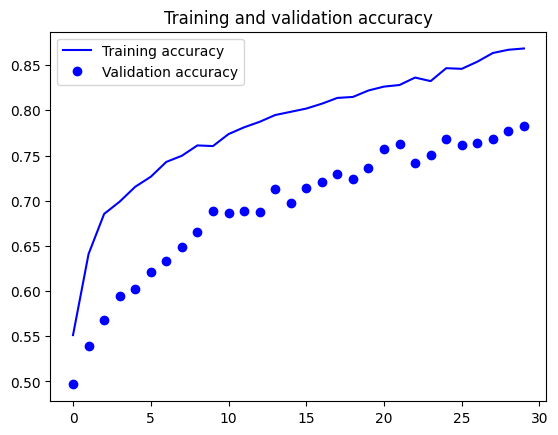

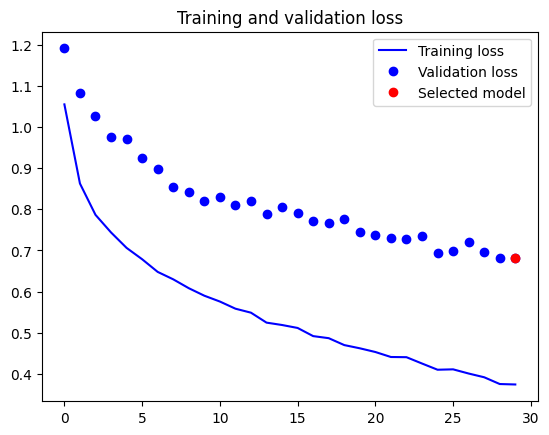

Lowest validation loss has been reached at epoch 29 with validation accuracy of 0.783


In [25]:
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

23/23 [==============================] - 7s 274ms/step - loss: 0.4409 - accuracy: 0.8577
Test accuracy: 0.858, test loss: 0.441
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 3 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 3 0 0 0 0 0 3 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 3 0 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 2 0
 0 2 0 0 0 0 0 0 0 0 0 2 2 0 0 2 2 2 2 2 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0
 1 1 1 1 1 1 1 2 0 1 1 1 1 1 0 1 2 1 1 1 1 1 1 2 1 1 0 1 1 0 1 0 1 1 2 1 1
 2 1 1 1 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 0 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 0 0 2

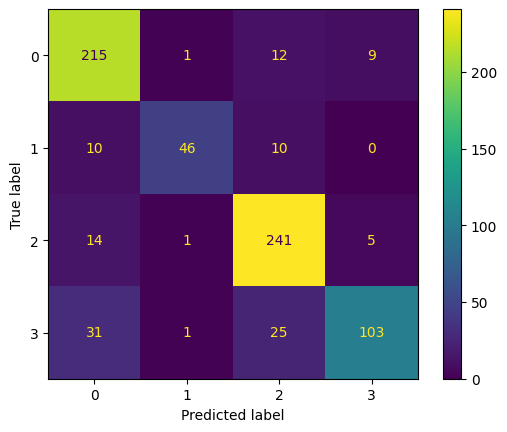

In [26]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))